In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from google.colab import files

In [2]:
def clean(raw):
    raw.drop(labels=['Name', 'Ticket', 'Cabin'], axis='columns', inplace=True)
    
    raw['Age'] = raw['Age'].fillna(raw['Age'].mean())
    raw['Embarked'] = raw['Embarked'].fillna(raw['Embarked'].mode()[0])
    
    raw['Fare'] = raw['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
    
    sex_dummy = pd.get_dummies(raw['Sex'])
    raw = pd.concat([raw, sex_dummy], axis=1)
    raw.drop('Sex', axis=1, inplace=True)

    embarked_dummy = pd.get_dummies(raw['Embarked'], prefix='Embarked')
    raw = pd.concat([raw, embarked_dummy], axis=1)
    raw.drop('Embarked', axis=1, inplace=True)

    pclass_dummy = pd.get_dummies(raw['Pclass'], prefix='Pclass')
    raw = pd.concat([raw, pclass_dummy], axis=1)
    raw.drop('Pclass', axis=1, inplace=True)
    
    raw.drop(
        labels=['Embarked_Q', 'SibSp', 'Age', 'Parch', 'Pclass_2'],
        axis='columns',inplace=True)
    
    return raw

In [6]:
x_train: pd.DataFrame = pd.read_csv('train.csv', index_col=0)
x_test: pd.DataFrame = pd.read_csv('test.csv', index_col=0)
y_train: pd.Series = x_train['Survived']
x_train.drop(labels=['Survived'], axis='columns', inplace=True)

x_train = clean(x_train)
x_test = clean(x_test)

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

params = {
    'n_estimators': [i for i in range(1, 16)],
}

base_boost = AdaBoostClassifier(random_state=3)
boost = GridSearchCV(
    base_boost,
    params,
    scoring='balanced_accuracy',
    n_jobs=-1,
    cv=5,
    return_train_score=True,
)
boost.fit(x_train, y_train)

results = pd.DataFrame(boost.cv_results_)
results = results[['param_n_estimators','mean_test_score',
                  'rank_test_score', 'mean_train_score']]
results.to_csv('boost_results.csv', index=False)
files.download('boost_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

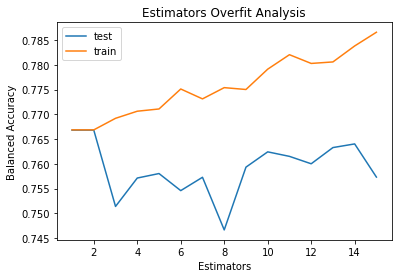

In [7]:
plt.plot(results['param_n_estimators'], results['mean_test_score'], label='test')
plt.plot(results['param_n_estimators'], results['mean_train_score'], label='train')

plt.xlabel('Estimators')
plt.ylabel('Balanced Accuracy')
plt.title('Estimators Overfit Analysis')
plt.legend()
plt.savefig('estimators.svg', format='svg')
files.download('estimators.svg')

In [9]:
boost = AdaBoostClassifier(n_estimators=2,
    random_state=3)
boost.fit(x_train, y_train)
predictions = pd.DataFrame()
predictions['Survived'] = boost.predict(x_test)
x_test: pd.DataFrame = pd.read_csv('test.csv', index_col=0)
predictions['PassengerId'] = x_test.index
predictions.to_csv('boost_output.csv', index=False)
files.download('boost_output.csv')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>